<a href="https://colab.research.google.com/github/SSSnoWW/AI_lessons/blob/lessons/%D0%9F%D1%80%D0%BE%D0%B4%D0%B2%D0%B8%D0%BD%D1%83%D1%82%D1%8B%D0%B9_%D0%B1%D0%BB%D0%BE%D0%BA_%7C_%D0%9E%D0%B1%D0%BD%D0%B0%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BE%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D0%BE%D0%B2_(Object_Detection)_%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C_YOLOv3_(%D0%BF%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_2)_%7C_%D0%A3%D0%98%D0%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/15jlTRqgJCqFbyw_bSg9UTB1cBjH5SYt_?usp=sharing)
2. [Практический ноутбук 1](https://colab.research.google.com/drive/1qNMeH5RPNG3kJQrH5FbyfsJUCzA3xPRO?usp=sharing)
3. Практический ноутбук 2


## Загрузка библиотек

In [ ]:
# для измерения времени обучения
import time

# для создания случайных величин
import random

# Импортируем tensorflow
import tensorflow as tf 

# бэкенд Keras
import tensorflow.keras.backend as K 

# функции для детализации и управления процессом обучения
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# функция для отрисовки структуры модели
from keras.utils.vis_utils import plot_model 

# Модули конвертации между RGB и HSV
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb 

# Модули работы с изображениями
from PIL import Image, ImageDraw, ImageFont 

import struct
import gdown

# библиотека numpy
import numpy as np

# Слои нейронной сети
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, Lambda

# Оптимизатор Adam
from tensorflow.keras.optimizers import Adam 

# работа со слоями
from keras.layers.merge import add, concatenate

# создание моделей
from keras.models import Model

# загрузчик сохраненных моделей
from keras.models import load_model

# итератор, повторно возвращающий указанный объект 
from itertools import repeat

# регуляризатор, который применяет штраф за регуляризацию L2
from tensorflow.keras.regularizers import l2 

# модуль для отрисовки изображения
from tensorflow.keras.preprocessing import image 

# Функция для отрисовки структуры модели
from keras.utils.vis_utils import plot_model 

# Импортируем tensorflow
import tensorflow as tf 

# gрямоугольник, определяемый точкой привязки xy , а также его шириной и высотой
from matplotlib.patches import Rectangle

# возвращение списка (возможно, пустого) путей, соответствующих шаблону pathname
from glob import glob

# библиотека для работы с файлами
import os

# визуализация 
from matplotlib import pyplot as plt
%matplotlib inline  

In [ ]:
if os.path.exists('D:/_AI/'):
   physical_devices = tf.config.experimental.list_physical_devices('GPU')
   assert len(physical_devices) > 0, "Ни один графический процессор не доступен"
   config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
   print("Доступен {} графический процессор".format(len(tf.config.experimental.list_physical_devices('GPU'))))
else:
   from google.colab import drive
   drive.mount('/content/drive/') # монтируем google диск 

Mounted at /content/drive/


Функция ошибки из лекции:

In [ ]:
def yolo_loss(inputs, num_anchors):

    ''' Функция рассчитывает отношение пересечение над объединениеми.
        Args:
            box1 - координаты рамки.
            box2 - координаты рамки.
        Return:
            значение ошибки IoU.
        '''
    # Порог вероятности обнаружения объекта
    ignore_thresh = .5 
    
    # Подсчитываем количество анкоров на каждом уровне сетки
    num_layers = num_anchors // 3 
    
    # Из входных данных выцепляем посчитанные моделью значения
    y_pred = inputs[:num_layers] 
    
    # Из входных данных выцепляем эталонные значения
    y_true = inputs[num_layers:] 
    
    # Задаем маску анкоров для каждого уровня сеток
    anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]] 
   
    # Получаем размерность входного изображения ( (13 х 13) * 32 = (416 х 416)) и приводим к типу элемента y_true[0]
    input_shape = K.cast(K.shape(y_pred[0])[1:3] * 32, K.dtype(y_true[0])) 
    
    # Получаем двумерный массив, соответствующий размерностям сеток ((13, 13), (26, 26), (52, 52))
    grid_shapes = [K.cast(K.shape(y_pred[l])[1:3], K.dtype(y_true[0])) for l in range(num_layers)]
    
    loss = 0 # Значение ошибки
    
    # Размер пакета
    m = K.shape(y_pred[0])[0] 

    # Преобразуем к типу y_pred[0]
    batch_size = K.cast(m, K.dtype(y_pred[0])) 
    
    for l in range(num_layers): # Пробегаем по всем трем уровням сеток
       
        # Получаем маску для сетки l-го уровня по вероятности определения объекта (5-ый параметр в списке общих параметров). 
        # В массиве object_mask будут значения, которые соответствуют только вероятности обнаружения объекта
        object_mask = y_true[l][..., 4:5] # Вернется набор данных вида: ([0][0][0][0]...[1]...[0])
        
        # Получаем аналогичную выборку для сетки l-го уровня с OHE (где записана позиция нашего класса)
        # В массиве true_class будут значения, которые соответсвуют только OHE представлению класса ядля данного уровня анкоров
        true_class = y_true[l][..., 5:] # Вернется набор данных вида: ([0][0][0][0]...[1]...[0])
        
        num_sub_anchors = len(anchors[anchor_mask[l]]) # Получаем количество анкоров для отдельного уровян сетки (3)
        
        # Решейпим анкоры отдельного уровня сетки и записываем в переменную anchors_tensor
        anchors_tensor = K.reshape(K.constant(anchors[anchor_mask[l]]), [1, 1, 1, num_sub_anchors, 2])
        
        # Создаем двумерный массив grid со значениями [[[0, 0] , [0, 1] , [0, 2] , ... , [0, k]], 
        #                                             [[1, 0] , [1, 1] , [1, 2] , ... , [1 ,k]],
        #                                             ...
        #                                             [[k, 0] , [k, 1] , [k, 2] , ... , [k, k]]]
        # где k - размерность сетки. Массив хранит индексы ячеек сетки
        grid_shape = K.shape(y_pred[l])[1:3] # Получаем ширину и высоту сетки
        grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),[1, grid_shape[1], 1, 1]) # Создаем вертикальную линию
        grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),[grid_shape[0], 1, 1, 1]) # Создаем горизонтальную линию
        grid = K.concatenate([grid_x, grid_y]) # Объединяем 
        grid = K.cast(grid, K.dtype(y_pred[l])) # Приводим к типу y_pred[l]
        
        # Решейпим y_pred[l]                 13                13              3              6
        feats = K.reshape(y_pred[l], [-1, grid_shape[0], grid_shape[1], num_sub_anchors, num_classes + 5]) 
        
        # -- Считаем ошибку в определении координат центра объекта

        # Получаем координаты центра объекта из спредиктенного значения
        pred_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats)) # три точки ... означают, что мы берем все параметры до запятой ,
        # Производим обратные вычесления для оригинальных значений из y_true для координат центра объекта
        true_xy = y_true[l][..., :2] * grid_shapes[l][::-1] - grid  # Реальные координаты центра bounding_box
        box_loss_scale = 2 - y_true[l][...,2:3] * y_true[l][...,3:4] # чем больше бокс, тем меньше ошибка
        # binary_crossentropy для истинного значения и спредиктенного (obect_mask для подсчета только требуемого значения)
        xy_loss = object_mask * box_loss_scale * K.binary_crossentropy(true_xy, feats[...,0:2], from_logits=True)

        # --- Считаем ошибку в определении координат ширины и высоты

        # Получаем значения ширины и высоты изображения из спредиктенного значения   
        pred_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats)) 
        # Производим обратные вычесления для оригинальных значений из y_true для ширины и высоты объекта
        true_wh = K.log(y_true[l][..., 2:4] / anchors[anchor_mask[l]] * input_shape[::-1]) 
        # Оставляем значение высоты и ширины только у тех элементов, где object_mask = 1
        true_wh = K.switch(object_mask, true_wh, K.zeros_like(true_wh)) 
        # Считаем значение ошибки в определении высоты и ширины
        wh_loss = object_mask * box_loss_scale * 0.5 * K.square(true_wh-feats[...,2:4])
        
        # Объединяем значения в один  массив
        pred_box = K.concatenate([pred_xy, pred_wh]) 
        
        # Считаем ошибку в определении обнаружения какого-либо класса
        # Для этого вначале надо отсечь все найденные объекты, вероятность которых меньше установленного значения ignore_thresh
        
        # Определяем массив, который будет хранить данные о неподходящих значениях
        ignore_mask = tf.TensorArray(K.dtype(y_true[0]), size=1, dynamic_size=True) 
        object_mask_bool = K.cast(object_mask, 'bool') # Приводим тип object_mask к типу 'bool'
        
        # Функция, определяющая данные, которые требуется игнорировать
        # Пробегаем по всем элементам пакета (b<m)
        # Получаем параметры реального bounding_box для текущей ячейки
        # Считаем IoU реального и спредиктенного
        # В зависимости от best_iou < ignore_thresh помечаем его как верно распознанный или неверено
        
        def loop_body(b, ignore_mask):

            ''' 
            Функция рассчитывает отношение пересечение над объединениеми.
            Args:
                b - элемент пакета
                ignore_mask - координаты рамки.
            Return:
                b+1 - следующий элемент пакета
                ignore_mask - координаты рамки.
             '''
            
            # в true_box запишутся первыые 4 параметра (центр, высота и ширина объекта) того элемента, значение которого в object_mask_bool равно True
            true_box = tf.boolean_mask(y_true[l][b,...,0:4], object_mask_bool[b,...,0]) 
            
            # Подсчитываем iou для спредиктенной ограничивающей рамки (pred_box) и оригинальной (true_box)
            iou = calc_iou(pred_box[b], true_box) 
            
            # Находим лучшую ограничивающую рамку
            best_iou = K.max(iou, axis=-1) 
            
            # Записываем в ignore_mask true или false в зависимости от (best_iou < ignore_thresh)
            ignore_mask = ignore_mask.write(b, K.cast(best_iou < ignore_thresh, K.dtype(true_box))) 
            
            return b+1, ignore_mask  
        
        # Пробегаем в цикле по всем элементам в пределах значения m (m = batch size)
        _, ignore_mask = tf.while_loop(lambda b,*args: b<m, loop_body, [0, ignore_mask]) 
        ignore_mask = ignore_mask.stack() # Приводим ignore_mask к тензору
        ignore_mask = K.expand_dims(ignore_mask, -1) # Добавляем еще одну размерность в конце ignore_mask
                 
        # Считаем значение ошибки
        # 1 компонента - для значений, которые были верно спредиктены
        # 2 компонентя - для значения, которые были неверно спредиктены
        confidence_loss = (
            object_mask * K.binary_crossentropy(object_mask, feats[...,4:5], from_logits=True) +
            (1-object_mask) * K.binary_crossentropy(object_mask, feats[...,4:5], from_logits=True) * ignore_mask
            )
        
        # Считаем ошибку в определении класса объекта
        class_loss = object_mask * K.binary_crossentropy(true_class, feats[...,5:], from_logits=True)
    
        # Считаем суммарную ошибку
        xy_loss = K.sum(xy_loss) / batch_size
        wh_loss = K.sum(wh_loss) / batch_size
        confidence_loss = K.sum(confidence_loss) / batch_size
        class_loss = K.sum(class_loss) / batch_size
        loss += xy_loss + wh_loss + confidence_loss + class_loss
                
    return loss # Возвращаем значение ошибки   

## Новые функции урока функции

In [ ]:
def calc_iou(input1, input2):
    
    ''' Функция подсчета коэффициента пересечения IoU
        Args: 
            input1 -
            input2 -
        Return:
            ошибка IoU 

        '''

    # Добавляем одну размерность
    input1 = K.expand_dims(input1, -2) 
    input2 = K.expand_dims(input2, 0)
    
    # Получаем координаты x,y центра 
    xy1 = input1[..., :2] 
    xy2 = input2[..., :2]

    # Получаем значения высоты и ширины
    wh1 = input1[..., 2:4] 
    wh2 = input2[..., 2:4] 
    
    # Делим значения высоты и ширины пополам
    wh_half1 = wh1 / 2. 
    wh_half2 = wh2 / 2.
    
    # Получаем значение, соответствующее верхнему левому углу
    top_left1 = xy1 - wh_half1 
    top_left2 = xy2 - wh_half2
    
    # Получаем значение, соотвествующее правому нижнему углу
    right_bottom1 = xy1 + wh_half1 
    right_bottom2 = xy2 + wh_half2

    # Берем максимальные координаты из левых верхних углов
    intersect_mins = K.maximum(top_left1, top_left2) 

    # Берем Минимальные координаты координаты из правых нижних углов
    intersect_maxes = K.minimum(right_bottom1, right_bottom2) 
    
    # Считаем ширину и высоту области пересечения
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.) 
    
    # Считаем площадь области пересечения
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1] 
    
    # Считаем площадь первых элементов
    area1 = wh1[..., 0] * wh1[..., 1] 

    # Считаем площадь вторых элементов
    area2 = wh2[..., 0] * wh2[..., 1] 
    
    return intersect_area / (area1 + area2 - intersect_area) 

In [ ]:
def data_generator(annotation_lines, batch_size, anchors, input_shape):
    
    ''' Функция генерации данных
        Args: 
            annotation_lines -
            batch_size -
            anchors - 
            input_shape -
        Return:
            порция данных для обучения 

        '''

    n = len(annotation_lines) # Получаем количество элементов в словаре аннотаций
    i = 0 # Задаем начальный индекс
    
    while True:
        
        image_data = [] # Массив для хранения изображений 416х416
        box_data = [] # Массив для хранения bounding_box данных
        
        for b in range(batch_size): # Пробегаем по всему batch_size
            
            if i==0: # Если первая итерация цикла
                np.random.shuffle(annotation_lines) # Перемешиваем элементы
            
            # Делаем аугментацию картинок и ограничивающих рамок
            image, box = augmentation(annotation_lines[i]) 
            
            # Добавляем полученную картинку в результирующий массив 
            image_data.append(image) 
            
            # Добавляем полученную ограничивающую рамку в массив bounfing_box
            box_data.append(box) 
            
            # Обновляем значение индека (не превышая общего количества элементов)
            i = (i+1) % n 
        
        # Преобразуем в numpy
        image_data = np.array(image_data)         
        box_data = np.array(box_data) 
        
        # По значению ограничивающей рамки получаем y_true 
        y_true = get_y(box_data, anchors, input_shape)        
        
        yield [image_data, *y_true], np.zeros(batch_size) 

In [ ]:
def augmentation(data):
    
    ''' Функция случайной аугментации данных
        Args: 
            data - изображения 
        Return:
            аугментированные изображение и bounding_box

        '''

    # Словарь с параметрами аугментации
    params = {
        'jitter' : .3,
        'hue'    : .1,
        'sat'    : 1.5,
        'val'    : 1.5
    }
    
    # Сплитим входную строку словаря
    data = data.split() 
    
    # Открываем изображение самолета
    image = Image.open(path + data[0]) 
    
    # Получаем ширину и высоту оригинального изображения
    width_i, height_i = image.size 
    
    # Получаем ширину и высоту входного изображения для модели RetinaNet
    widht_shape, height_shape = input_shape[:2] 
    
    # Получаем координаты ограничивающей рамки
    box = np.array([np.array(list(map(lambda x: int(float(x)),box.split(',')))) for box in data[1:]])
    
    # Случайным образом масштабируем изображение
    new_ar = widht_shape / height_shape * rand(1 - params['jitter'], 1 + params['jitter']) / rand(1 - params['jitter'], 1 + params['jitter'])
    scale = rand(.65, 2) 
    if new_ar < 1:        
        nh = int(scale * height_shape)
        nw = int(nh * new_ar)
    else:
        nw = int(scale * widht_shape)
        nh = int(nw / new_ar)
    image = image.resize((nw, nh), Image.BICUBIC)
    
    # Преобразуем картинку к input_shape и размещаем случайным образом
    dx = int(rand(0, widht_shape - nw))
    dy = int(rand(0, height_shape - nh))
    new_image = Image.new('RGB', (widht_shape, height_shape), (128,128,128))
    new_image.paste(image, (dx, dy))
    image = new_image
    
    # С вероятностью 50% отображаем по горизонтале
    flip = rand() < .5
    if flip:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    
    # Случайным образом меняем освещенность, экспозицию, гамму изображения
    hue1 = rand(-params['hue'], params['hue'])
    sat1 = rand(1, params['sat']) if rand() < .5 else 1 / rand(1, params['sat'])
    val1 = rand(1, params['val']) if rand() < .5 else 1 / rand(1, params['val'])
    x = rgb_to_hsv(np.array(image) / 255.)
    x[..., 0] += hue1
    x[..., 0][x[..., 0] > 1] -= 1
    x[..., 0][x[..., 0] < 0] += 1
    x[..., 1] *= sat1
    x[..., 2] *= val1
    x[x > 1] = 1
    x[x < 0] = 0
    image_data = hsv_to_rgb(x) # Получаем окончательный массив
    
    max_boxes = 4 # Устанавливаем максимальное количество рамок на изображении
    
    # Корректируем параметры ограничивающей рамки в соответсвии с проведенными выше преобразованиями
    box_data = np.zeros((max_boxes,5)) # Создаем массив из нулей размерностью (max_boxes, 5) 
    
    if len(box)>0:                
        # Ресайзим и перемещаем
        box[:, [0,2]] = box[:, [0,2]] * nw/width_i + dx
        box[:, [1,3]] = box[:, [1,3]] * nh/height_i + dy
        
        # Отражаем по горизонтале
        if flip: box[:, [0,2]] = widht_shape - box[:, [2,0]]
        box[:, 0:2][box[:, 0:2]<0] = 0
        # Ограничиваем, если вышли за пределы input_shape
        box[:, 2][box[:, 2] > widht_shape] = widht_shape
        box[:, 3][box[:, 3] > height_shape] = height_shape
        # Считаем высоту и ширину рамок и оставляем только те, значения которых больше 1
        box_w = box[:, 2] - box[:, 0] # xRight - xLeft
        box_h = box[:, 3] - box[:, 1] # yBottom - yTop
        box = box[np.logical_and(box_w > 1, box_h > 1)]
        
        if len(box) > max_boxes: # Оставляем только max_boxes рамок
            box = box[:max_boxes]
        box_data[:len(box)] = box # Записываем данные в box_data
    
    return image_data, box_data # Возвращаем аугментированные изображение и bounding_box  

In [ ]:
def get_y(true_boxes, anchors, input_shape):
    
    ''' Функция подсчета y
        Args: 
            true_boxes -
            anchors -
            input_shape - 
        Return:
            y_true - 

        '''
    # Получаем количество анкоров для каждого уровня сеток
    num_layers = len(anchors) // 3 
    
    # Задаем маску анкоров для каждого уровня
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] 
    
    # Преобразуем bounding_box в numpy
    true_boxes = np.array(true_boxes, dtype='float32') 

    # Преобразуем input_shape в numpy
    input_shape = np.array(input_shape, dtype='int32') 

    # Получаем координаты центра bounding_box (xRight+xLeft / 2)
    boxes_xy = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) // 2 

    # Получаем ширину и высоту bounding_box (xRight - xLeft)
    boxes_wh = true_boxes[..., 2:4] - true_boxes[..., 0:2] 

    # Получаем координаты центра bounding_box в относительных координатах
    true_boxes[..., 0:2] = boxes_xy / input_shape[::-1] 

    # Получаем высоту и ширину bounding_box В относительных значениях
    true_boxes[..., 2:4] = boxes_wh / input_shape[::-1] 

    # Получаем количество элементов в batch_size
    m = true_boxes.shape[0] 

    # Создаем список из трех элементов ([13, 13], [26, 26], [52, 52])
    grid_shapes = [input_shape//{0:32, 1:16, 2:8}[l] for l in range(num_layers)] 

    # Создаем 0-вые списки для y_true
    # y_true[0].shape = (None, 13, 13, 3, 6)
    # y_true[1].shape = (None, 26, 26, 3, 6)
    # y_true[2].shape = (None, 52, 52, 3, 6)
    y_true = [np.zeros((m,grid_shapes[l][0],grid_shapes[l][1],len(anchor_mask[l]),5+num_classes),
        dtype='float32') for l in range(num_layers)]

    anchors = np.expand_dims(anchors, 0) # Добавляем размерность

    # Параметры для IoU
    anchor_maxes = anchors / 2. 
    anchor_mins = -anchor_maxes
    valid_mask = boxes_wh[..., 0] > 0

    for b in range(m):
        
        wh = boxes_wh[b, valid_mask[b]] # Получаем ширину и высоту текущего bounding_box
        
        if len(wh)==0: continue # Выходим если она нулевая
        
        wh = np.expand_dims(wh, -2) # Добавляем размерность
        
        # Параметры для IoU
        box_maxes = wh / 2.
        box_mins = -box_maxes
        
        intersect_mins = np.maximum(box_mins, anchor_mins) 
        intersect_maxes = np.minimum(box_maxes, anchor_maxes)
        intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
        box_area = wh[..., 0] * wh[..., 1]
        anchor_area = anchors[..., 0] * anchors[..., 1]
        iou = intersect_area / (box_area + anchor_area - intersect_area)

        best_anchor = np.argmax(iou, axis=-1) # Находим лучшее значение iou для всех анкоров 

        for t, n in enumerate(best_anchor): 
            
            for l in range(num_layers):
                
                if n in anchor_mask[l]:
                    i = np.floor(true_boxes[b,t,0] * grid_shapes[l][1]).astype('int32')
                    j = np.floor(true_boxes[b,t,1] * grid_shapes[l][0]).astype('int32')
                    k = anchor_mask[l].index(n)
                    c = true_boxes[b,t, 4].astype('int32')
                    y_true[l][b, j, i, k, 0:4] = true_boxes[b,t, 0:4]
                    y_true[l][b, j, i, k, 4] = 1
                    y_true[l][b, j, i, k, 5+c] = 1
    
    return y_true

In [ ]:
# получения координат ограничивающей рамки
def getXY(image):

    ''' Функция получения координат ограничивающей рамки
        Args: 
            image -
        Return:
            координаты ограничивающей рамки [Xmin, Ymin, Xmax, Ymax]

        '''
    # Считываем красный канал изображения
    image_red = np.array(image)[:,:,0]  
    
    # Получаем индексы пискселей красного цвета
    indexes = np.where(image_red > 20) 
    
    return [min(indexes[1]), min(indexes[0]), max(indexes[1]), max(indexes[0]) ]

In [ ]:
def rand(a=0, b=1):
    
    return np.random.rand()*(b-a) + a

## Загрузка набора данных
Мы будем обучать YOLOv3 с нуля на фотографиях самолётов. Скачать набор фотографий <a href = 'https://storage.googleapis.com/datasets_ai/Advanced/9_OD/airplanes.zip'>можно по этой ссылке</a>. Затем загрузите архив с фотографиями на свой гугл диск и измените путь (кодовая ячейка ниже), если путь к нему отличается.

In [ ]:
# Скачиваем датасет с изображениями для тестирования модели
import gdown

gdown.download('https://storage.googleapis.com/datasets_ai/Advanced/9_OD/airplanes.zip', None, quiet=True)

# Распаковываем датасет
!unzip -q airplanes.zip -d dataset2

source_dir2 = 'dataset2/airplanes/Airplane/'

Получаем список фотографий с путями

In [ ]:
def get_file_paths(train_folder_with_tamplate):
    
    ''' 
    Функция для получения списка файлов в папке с путями к ним 
    Args:
        train_folder_with_tamplate - адрес папки
    Return:
        список файлов с путями    
        '''
    
    return glob(train_folder_with_tamplate, recursive=True) 

In [ ]:
# Получаем список путей ко всем файлам с их именами
file_list = get_file_paths(source_dir2+'/**'+ '/*.jpg')

print(len(file_list))

1000


Смотрим фотографии из базы

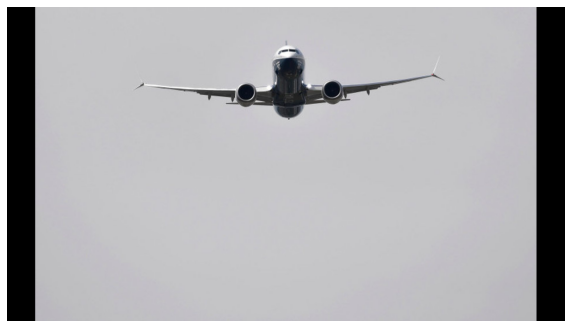

In [ ]:
# загружаем изображение
data = plt.imread(file_list[5])
plt.figure(1, figsize=(10,10))  
  
# выводим изображение
plt.axis('off')
plt.imshow(data)

Загружаем готовые данные в виде numpy массива для обучения на них нейросети.

In [ ]:
All_data = np.load(gdown.download('https://storage.googleapis.com/datasets_ai/Advanced/9_OD/aircraft_np_base.npy', None, quiet=True))
val_split = 0.1 # Коэфициент разделения на обучающую и проверочную выборку

# Перемешаем значения в массиве
np.random.seed(17)
np.random.shuffle(All_data)
np.random.seed(None)

num_val = int(len(All_data) * val_split) # Количество элементов проверочной выборки
num_train = len(All_data) - num_val # Количество элементов обучающей выборки
print (num_val)
print (num_train)
print (All_data.shape)

100
900
(1000,)


Готовые данные представляют из себя массив в котором содержится информация о пути к файлу, его имени и координаты ограничивающей рамки (bounding box)

In [ ]:
All_data[0]

'Airplane/airplane_781.jpg 173,272,1743,783,0'

In [ ]:
All_data.shape

(1000,)

Чтобы путь к фотографиям совпадал, с тем, который закодирован в numpy массиве, фотографии самолетов должны находится в папке Airplane

Код ниже загружает фотографию самолета используя информацию записанную в файле <b>All_data</b>, разбивая ее на две части. До пробела извлекается путь и имя файла фотографии, после пробела координаты рамки (bounding box). Затем строиться изображение, а на нем отображается рамка объекта, после чего изображение с выделенным объектом выводится на экран.

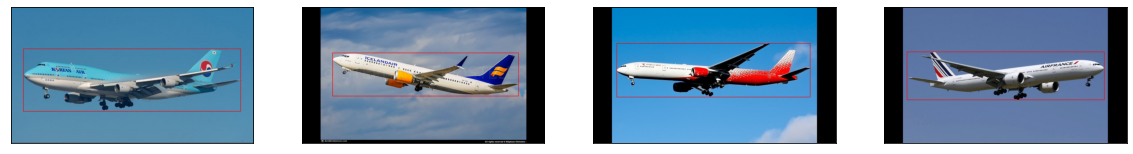

In [ ]:
# Открываем файл сегментированной модели
n_img_show = 4
plt.figure(figsize = (20,15))

for i in range(n_img_show):
  
  file_name, box_coord = All_data[10+i].split(' ')
  minX,minY,maxX,maxY,_ = box_coord.split(',')
  
  # Загружаем изображение сегментированной модели
  image = Image.open('dataset2/airplanes/' + file_name)

  # Создаем экземпляр изображения
  img1 = ImageDraw.Draw(image) 
  img1.rectangle([int(minX),int(minY),int(maxX),int(maxY)], outline = 'red', width=4)
  
  ax=plt.subplot(1,n_img_show,i+1)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.imshow(image)

# Рисуем изображение
plt.show() 


**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/15jlTRqgJCqFbyw_bSg9UTB1cBjH5SYt_?usp=sharing)
2. [Практический ноутбук 1](https://colab.research.google.com/drive/1qNMeH5RPNG3kJQrH5FbyfsJUCzA3xPRO?usp=sharing)
3. Практический ноутбук 2
